### Prerequisites

Installing `tflite` as we are converting TFLite model.

In [ ]:
!pip install tflite apache-tvm opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 MB 12.4 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import tvm
import tflite
from tvm import relay
from tvm.contrib import graph_executor
import matplotlib.pyplot as plt
from tvm.driver import tvmc
from tvm import autotvm
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner

In [ ]:
target = "llvm -mtriple=x86_64-linux-gnu"

### Convert TF Lite model to TVM model and fix layout for tuning

In [ ]:
tflite_model_buf = open('face_detection_front.tflite', "rb").read()
tflite_model = tvm.relay.frontend.from_tflite(
    tflite.Model.GetRootAsModel(tflite_model_buf, 0),
    shape_dict={"input": (1, 128, 128, 3)},
    dtype_dict={"input": "float32"}
)
mod, params = tflite_model


In [ ]:
target = "llvm"
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)

In [ ]:
def load_image_for_inference(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = (image.astype(np.float32) - 128) / 128.0
    image = np.expand_dims(image, axis=0)
    return image

image = load_image_for_inference('face.jpeg')

In [ ]:
def run_inference(module, image):
    # Set input and run the model
    module.set_input("input", tvm.nd.array(image))
    module.run()

    # Extract outputs from the model
    bboxes_and_keypoints = module.get_output(0).numpy()  # (1, 896, 16)
    detection_scores = module.get_output(1).numpy()     # (1, 896, 1)

    return bboxes_and_keypoints, detection_scores


In [ ]:
def create_blazeface_anchors(input_w, input_h):
    """
    Generate anchors following the original BlazeFace model spec.
    """
    strides = [8, 16]
    anchors_per_layer = [2, 6]

    anchors = []
    for stride, num_anchors in zip(strides, anchors_per_layer):
        grid_cols = (input_w + stride - 1) // stride
        grid_rows = (input_h + stride - 1) // stride

        for grid_y in range(grid_rows):
            anchor_y = stride * (grid_y + 0.5)
            for grid_x in range(grid_cols):
                anchor_x = stride * (grid_x + 0.5)
                for _ in range(num_anchors):
                    anchors.append((anchor_x, anchor_y))
    return np.array(anchors, dtype=np.float32)


In [ ]:
# Create a graph executor
module = graph_executor.GraphModule(lib["default"](tvm.cpu()))

# Set input and run
module.set_input("input", tvm.nd.array(image))
module.run()

# Extract model output
tvm_output = module.get_output(0).numpy()
print("Output shape:", tvm_output.shape)

Output shape: (1, 896, 16)


In [ ]:
bboxes_and_keypoints, detection_scores = run_inference(module, image)

In [ ]:
def process_outputs(bboxes_and_keypoints, detection_scores, anchors, input_w, input_h, score_threshold=0.75, iou_threshold=0.3):
    # Extract scores and apply sigmoid
    scores = 1 / (1 + np.exp(-detection_scores[0, :, 0]))

    # Filter detections by score threshold
    valid_indices = np.where(scores >= score_threshold)[0]
    valid_bboxes = bboxes_and_keypoints[0, valid_indices]
    valid_scores = scores[valid_indices]

    # Process bounding boxes and keypoints
    detected_faces = []
    for idx, bbox_keypoint in enumerate(valid_bboxes):
        sx, sy, w, h = bbox_keypoint[:4]
        score = valid_scores[idx]
        anchor = anchors[valid_indices[idx]]

        # Decode bounding box
        cx = sx + anchor[0]
        cy = sy + anchor[1]

        cx /= input_w
        cy /= input_h
        w /= input_w
        h /= input_h

        xmin = max(0, cx - w / 2)
        ymin = max(0, cy - h / 2)
        xmax = min(1, cx + w / 2)
        ymax = min(1, cy + h / 2)

        # Extract keypoints
        keypoints = []
        for kp_idx in range(6):
            kp_x = bbox_keypoint[4 + 2 * kp_idx]
            kp_y = bbox_keypoint[4 + 2 * kp_idx + 1]

            kp_x = (kp_x + anchor[0]) / input_w
            kp_y = (kp_y + anchor[1]) / input_h

            keypoints.append((kp_x, kp_y))

        detected_faces.append({
            "score": score,
            "bbox": (xmin, ymin, xmax, ymax),
            "keypoints": keypoints
        })

    # Apply Non-Max Suppression
    filtered_faces = non_max_suppression(detected_faces, iou_threshold)
    return filtered_faces

def non_max_suppression(faces, iou_thresh=0.3):
    faces = sorted(faces, key=lambda x: x["score"], reverse=True)
    selected_faces = []

    def calc_iou(face0, face1):
        xmin0, ymin0, xmax0, ymax0 = face0["bbox"]
        xmin1, ymin1, xmax1, ymax1 = face1["bbox"]

        intersect_xmin = max(xmin0, xmin1)
        intersect_ymin = max(ymin0, ymin1)
        intersect_xmax = min(xmax0, xmax1)
        intersect_ymax = min(ymax0, ymax1)

        intersect_area = max(0, intersect_xmax - intersect_xmin) * max(0, intersect_ymax - intersect_ymin)
        area0 = (xmax0 - xmin0) * (ymax0 - ymin0)
        area1 = (xmax1 - xmin1) * (ymax1 - ymin1)

        return intersect_area / (area0 + area1 - intersect_area)

    for face in faces:
        keep = True
        for sel_face in selected_faces:
            if calc_iou(face, sel_face) >= iou_thresh:
                keep = False
                break
        if keep:
            selected_faces.append(face)
    return selected_faces

def visualize_detections(image, faces, input_w=128, input_h=128):
    # Resize and prepare image for visualization
    display_image = cv2.resize(image[0], (input_w, input_h))
    display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(display_image)

    for face in faces:
        xmin, ymin, xmax, ymax = face["bbox"]
        score = face["score"]

        # Draw bounding box
        rect = plt.Rectangle(
            (xmin * input_w, ymin * input_h),
            (xmax - xmin) * input_w,
            (ymax - ymin) * input_h,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # Draw keypoints
        for kp_x, kp_y in face["keypoints"]:
            ax.plot(kp_x * input_w, kp_y * input_h, 'bo', markersize=6)

        # Display score
        ax.text(
            xmin * input_w, ymin * input_h - 5, f"Score: {score:.2f}",
            color="red", fontsize=12, weight='bold'
        )

    ax.axis("off")
    plt.show()

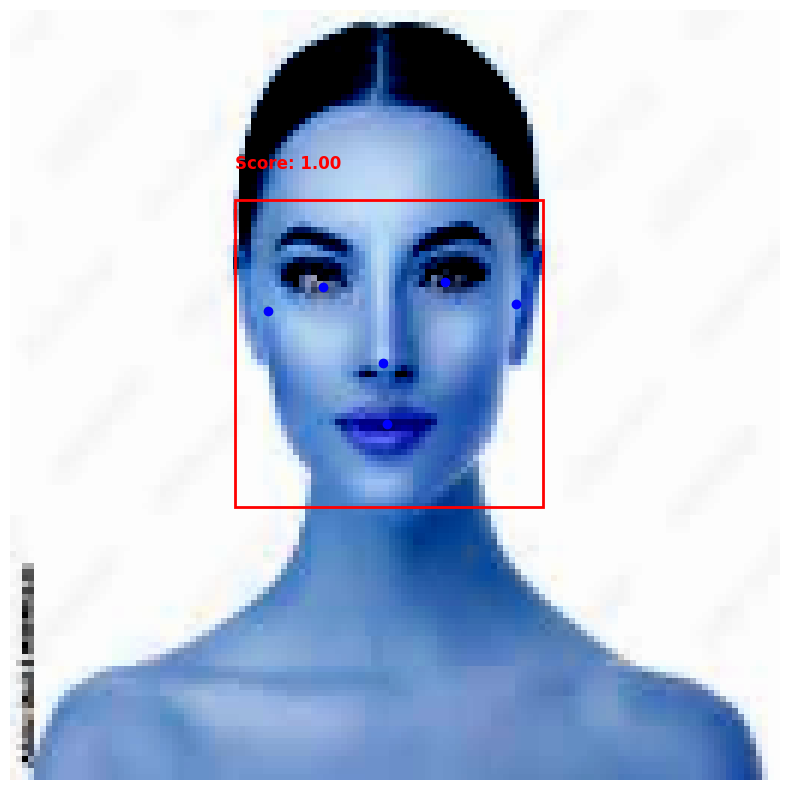

In [ ]:
# Run TVM inference
bboxes_keypoints, detection_scores = run_inference(module, image)

# Generate anchors
input_w, input_h = 128, 128
anchors = create_blazeface_anchors(input_w, input_h)

# Process model outputs
detected_faces = process_outputs(bboxes_keypoints, detection_scores, anchors, input_w, input_h)

# Visualize the results
visualize_detections(image, detected_faces)

### Save TVMC model

Let's save our untuned model.

In [ ]:
def convert_params_to_numpy(parameters: dict[str: tvm.nd.NDArray]) -> dict[str: np.ndarray]:
    patched_parameters = {}

    for k, v in parameters.items():
        patched_parameters[k] = v.numpy()

    return patched_parameters

In [ ]:
def load_tvm_parameters(path: str) -> dict[str: tvm.nd.NDArray]:
    raw_parameters = np.load(path)

    patched_parameters = {}

    for k, v in raw_parameters.items():
        patched_parameters[k] = tvm.nd.array(v)

    return patched_parameters

In [ ]:
def add_prefix_to_parameters(parameters: dict,
                             prefix: str) -> dict:
    patched_parameters = {}

    for k, v in parameters.items():
        patched_parameters[f"{prefix}{k}"] = v

    return patched_parameters

In [ ]:
def create_tvmc_model(model,
                      parameters,
                      file_name):
    with open(f"{file_name}.txt", "w") as f:
        f.write(repr(mod_nchw))

    return tvmc.load(f"{file_name}.txt", shape_dict={"input": (1, 128, 128, 3), **vparams }, model_format="relay")

In [ ]:
with tvm.transform.PassContext(opt_level=3):
    mod_nchw = tvm.relay.transform.InferType()(mod)
    mod_nchw = tvm.relay.transform.ConvertLayout({"nn.conv2d": ["NCHW", "OIHW"],
                                                  "image.resize2d": ["NCHW"],
                                                  "nn.conv2d_transpose": ["NCHW", "OIHW"]})(mod_nchw)

In [ ]:
vparams = add_prefix_to_parameters(params, prefix='v')

In [ ]:
np.save('parameters', convert_params_to_numpy(vparams))

In [ ]:
tvmc_model = create_tvmc_model(mod_nchw, vparams, file_name='face_detection')

In [ ]:
tvmc.compile(tvmc_model, target=target,
             tuning_records='tvmc_compilation.log',
             package_path="face_detection_base.tar")

#### Check inference on TVMC model

In [35]:
package = tvmc.TVMCPackage(package_path="face_detection_base.tar")

inputs = {"input": image, **vparams}
num_iter = 10
result = tvmc.run(package, device="cpu", inputs=inputs,
                  benchmark=True, number=num_iter)

tvmc_output = result.outputs["output_0"]
print('output shape:', tvmc_output.shape)

2024-12-10 20:41:35.963 INFO load_module /tmp/tmphyoym85f/mod.so


output shape: (1, 896, 16)


### AutoTVM tuning

In [ ]:
log_file = "statistics.log"

In [ ]:
def evaluate_performance(input_name, lib, data_shape, dtype="float32"):
    # upload parameters to device
    dev = tvm.cpu()
    data_tvm = tvm.nd.array((np.random.uniform(size=data_shape)).astype(dtype))
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data_tvm)

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))

In [ ]:
# extract workloads from relay program
def extract_tasks_autotvm(mod, target, params):
    print("Extract tasks...")
    print(mod)
    tasks = autotvm.task.extract_from_program(
        mod, target=target, params=params
    )
    assert(len(tasks) > 0)
    return tasks

def evaluate_autotvm(input_name, model, data_shape, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext():
        print("Compile...")
        lib = relay.build(model, target=target, params=params)
        evaluate_performance(input_name, lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with autotvm.apply_history_best(log_file):
        print("Compile...")
        with tvm.transform.PassContext():
            lib = relay.build(model, target=target, params=params)
        evaluate_performance(input_name, lib, data_shape)

In [ ]:
import multiprocessing
import os
# import autotvm
# from autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner
# Set number of threads used for tuning based on the number of
# physical CPU cores on your machine.
num_threads = multiprocessing.cpu_count()
print("Num threads: ", num_threads)
os.environ["TVM_NUM_THREADS"] = str(num_threads)

Num threads:  2


In [ ]:
tuning_option = {
    "log_filename": log_file,
    "tuner": "xgb",
    "early_stopping": False,
    "n_trial": 42,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(),
        runner=autotvm.LocalRunner(
            number=1, repeat=10, min_repeat_ms=0, enable_cpu_cache_flush=True
        ),
    ),
}

In [ ]:
def run_tuning_autotvm(
    tasks, measure_option, n_trial=0, tuner="gridsearch", early_stopping=None, log_filename="tuning.log"
):
    for i, task in enumerate(tasks):
        prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        if tuner == "xgb" or tuner == "xgb-rank":
            tuner_obj = XGBTuner(task, loss_type="rank")
        elif tuner == "ga":
            tuner_obj = GATuner(task, pop_size=50)
        elif tuner == "random":
            tuner_obj = RandomTuner(task)
        elif tuner == "gridsearch":
            tuner_obj = GridSearchTuner(task)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        if n_trial == 0:
          n_trial = len(task.config_space)
        tuner_obj.tune(
            n_trial=n_trial,
            early_stopping=early_stopping,
            measure_option=measure_option,
            callbacks=[
                autotvm.callback.progress_bar(n_trial, prefix=prefix),
                autotvm.callback.log_to_file(log_filename),
            ],
        )

In [ ]:
tasks = extract_tasks_autotvm(mod_nchw, target, params)
run_tuning_autotvm(tasks, **tuning_option)

Extract tasks...
def @main(%input: Tensor[(1, 128, 128, 3), float32] /* ty=Tensor[(1, 128, 128, 3), float32] */, %v_param_1: Tensor[(5, 5, 3, 24), float32] /* ty=Tensor[(5, 5, 3, 24), float32] */, %v_param_2: Tensor[(24), float32] /* ty=Tensor[(24), float32] */, %v_param_3: Tensor[(3, 3, 24, 1), float32] /* ty=Tensor[(3, 3, 24, 1), float32] */, %v_param_4: Tensor[(24), float32] /* ty=Tensor[(24), float32] */, %v_param_5: Tensor[(1, 1, 24, 24), float32] /* ty=Tensor[(1, 1, 24, 24), float32] */, %v_param_6: Tensor[(24), float32] /* ty=Tensor[(24), float32] */, %v_param_7: Tensor[(3, 3, 24, 1), float32] /* ty=Tensor[(3, 3, 24, 1), float32] */, %v_param_8: Tensor[(24), float32] /* ty=Tensor[(24), float32] */, %v_param_9: Tensor[(1, 1, 24, 28), float32] /* ty=Tensor[(1, 1, 24, 28), float32] */, %v_param_10: Tensor[(28), float32] /* ty=Tensor[(28), float32] */, %v_param_11: Tensor[(3, 3, 28, 1), float32] /* ty=Tensor[(3, 3, 28, 1), float32] */, %v_param_12: Tensor[(28), float32] /* ty=Tensor

In [ ]:
evaluate_autotvm("input", mod_nchw, (1, 128, 128, 3), 'statistics.log', target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  13.0259      10.1640      20.4289       8.4849       5.2794   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  11.9442       8.9644      18.9474       7.9207       4.9703   
               


### Exporting the library using `export_library`

In [ ]:
from tvm import transform

with autotvm.apply_history_best(log_file):
  with transform.PassContext(opt_level=3):
    lib = relay.build(mod_nchw, target=target, params=params)
    lib.export_library('./face_detection_optimized.so')

In [36]:
loaded_lib = tvm.runtime.load_module('./face_detection_optimized.so')

In [ ]:
module = graph_executor.GraphModule(loaded_lib["default"](tvm.cpu()))
module.set_input("input", tvm.nd.array(image))

module.run()

tvm_output = module.get_output(0).numpy()

print('output shape:', tvm_output.shape)

output shape: (1, 896, 16)


In [38]:
!ls

face_detection_base.tar      face_detection_optimized.so  face.jpeg	  sample_data
face_detection_front.tflite  face_detection.txt		  parameters.npy  statistics.log


In [39]:
!cp face_detection_optimized.so face_detection_optimized.so.zip